In [1]:
import os
import xml.etree.ElementTree as ET
from PIL import Image
import torch
import torchvision.transforms as T
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torch.utils.data import DataLoader, random_split
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
from sklearn.model_selection import train_test_split

In [2]:
# Function to parse XML files and extract bounding boxes
def parse_annotation(xml_file):
  tree = ET.parse(xml_file)
  root = tree.getroot()
  boxes = []
  for obj in root.findall('object'):
    bbox = obj.find('bndbox')
    xmin = int(bbox.find('xmin').text)
    ymin = int(bbox.find('ymin').text)
    xmax = int(bbox.find('xmax').text)
    ymax = int(bbox.find('ymax').text)
    boxes.append([xmin, ymin, xmax, ymax])
  return boxes

In [3]:
# Custom dataset class for images and their respective annotations
class InsulatorDataset(torch.utils.data.Dataset):
  def __init__(self, root_dir, transform=None):
    self.root_dir = root_dir
    self.transform = transform or T.ToTensor()
    self.imgs = sorted(os.listdir(os.path.join(root_dir, "Images")))
    self.xmls = sorted(os.listdir(os.path.join(root_dir, "Annotations")))

  def __len__(self):
    return len(self.imgs)

  def __getitem__(self, idx):
    img_path = os.path.join(self.root_dir, "Images", self.imgs[idx])
    img = Image.open(img_path).convert("RGB")
    img = self.transform(img)

    xml_path = os.path.join(self.root_dir, "Annotations", self.xmls[idx])
    boxes = parse_annotation(xml_path)

    target = {'boxes': torch.as_tensor(boxes, dtype=torch.float32),
              'labels': torch.ones((len(boxes),), dtype=torch.int64)}

    return img, target

In [4]:
# Get model
def get_model(num_classes):
  model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
  in_features = model.roi_heads.box_predictor.cls_score.in_features
  model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
  return model

In [5]:
def train_model(model, data_loader, device, num_epochs=10):
  model.train()
  optimizer = torch.optim.SGD(model.parameters(), lr=0.005, momentum=0.9, weight_decay=0.0005)

  for epoch in range(num_epochs):
      epoch_loss = 0
      for imgs, targets in data_loader:
          imgs = [img.to(device) for img in imgs]
          targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

          optimizer.zero_grad()
          loss_dict = model(imgs, targets)
          losses = sum(loss for loss in loss_dict.values())
          losses.backward()
          optimizer.step()
          epoch_loss += losses.item()

      print(f"Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss}")

  torch.save(model.state_dict(), 'insulator_detector.pth')
  print("Model saved to insulator_detector.pth")

In [6]:
def load_model(device, model_path='insulator_detector.pth'):
  model = get_model(num_classes=2)
  model.load_state_dict(torch.load(model_path))
  model.to(device)
  model.eval()
  return model

In [7]:
def predict_and_display(model, img, device):
  img_tensor = img.unsqueeze(0).to(device)
  with torch.no_grad():
      predictions = model(img_tensor)
  boxes = predictions[0]['boxes'].cpu().numpy()
  scores = predictions[0]['scores'].cpu().numpy()
  return boxes[scores >= 0.5]  # Apply score threshold for filtering

In [8]:
def display_predictions(model, data_loader, device):
  fig, axs = plt.subplots(1, 5, figsize=(20, 5))
  model.eval()
  for i, (img, _) in enumerate(data_loader):
    if i == 5: break
    boxes = predict_and_display(model, img[0], device)
    img_np = np.array(img[0].permute(1, 2, 0).cpu())

    axs[i].imshow(img_np)
    for box in boxes:
      xmin, ymin, xmax, ymax = box
      rect = patches.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin, linewidth=2, edgecolor='r', facecolor='none')
      axs[i].add_patch(rect)
      axs[i].axis('off')
  plt.show()

In [9]:
# Load Dataset and Split
root_dir = "/content/drive/MyDrive/drone_image"
dataset = InsulatorDataset(root_dir=root_dir)
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

In [10]:
train_loader = DataLoader(train_dataset, batch_size=2, shuffle=True, collate_fn=lambda x: tuple(zip(*x)))
val_loader = DataLoader(val_dataset, batch_size=1, shuffle=False, collate_fn=lambda x: tuple(zip(*x)))

In [11]:
# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [12]:
# Initialize and Train Model
model = get_model(num_classes=2)
model.to(device)
train_model(model, train_loader, device)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth
100%|██████████| 160M/160M [00:00<00:00, 215MB/s]


Epoch 1/10, Loss: 49.70124042034149
Epoch 2/10, Loss: 33.46848091483116
Epoch 3/10, Loss: 28.17268705368042
Epoch 4/10, Loss: 27.249617338180542
Epoch 5/10, Loss: 24.16761140525341
Epoch 6/10, Loss: 23.34627863764763
Epoch 7/10, Loss: 22.186794817447662
Epoch 8/10, Loss: 21.509198740124702
Epoch 9/10, Loss: 19.807764872908592
Epoch 10/10, Loss: 18.157872036099434
Model saved to insulator_detector.pth


<ipython-input-6-89faeb511ad2>:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path))


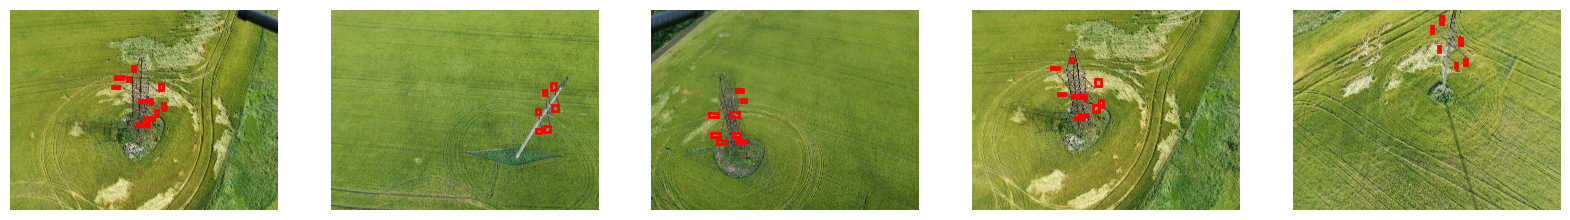

In [13]:
# Load Trained Model and Display Validation Predictions
model = load_model(device)
display_predictions(model, val_loader, device)